### Introduction to Data Science
## Homework 3: Due 5pm to My Mailbox (2nd Floor, 19 W 4th St) Wednesday April 19th

Student Name: Xi Mei

Student Netid: xm518
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [30]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import os
def cleanBosonData(infile_name):
    #Get the data
    datadir = '\\'.join(os.getcwd().split('\\')[0:]) + '\\data\\'
    data = pd.read_csv(datadir + infile_name, sep=',',index_col=0)
    
    #Replace minority class with '1' and majority class with '0' on the column 'Label' and rename it as 'Y': 
    data['Label']=data['Label'].replace([data['Label'].value_counts().idxmax(),data['Label'].value_counts().idxmin()],[0,1])
    data=data.rename(columns={"Label": "Y"})
    
    #Replace all -999 with NaN
    data=data.replace(-999,np.nan)
    X_col=data.shape[1] #Get the original number of columns
    
    #Append 'mv' columns to the original dataframe
    for i in data.columns:
        if (np.any(data[i].isnull())):
            data[i+'_mv']=0
            data.loc[data[i].isnull(),i+'_mv']=1
            data[i]=data[i].replace(np.nan,data[i].mean())
    
    #Rescale the features(i.e.X) and exchange it with the original X in the dataframe
    data_clean=preprocessing.scale(data.iloc[:,:X_col-1])
    data.iloc[:,:X_col-1]=data_clean
    return data

### Part 2: Basic evaluations
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`boson_training_cut_2000.csv` and `boson_testing_cut.csv`) and use them as training and testing data sets.

In [31]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

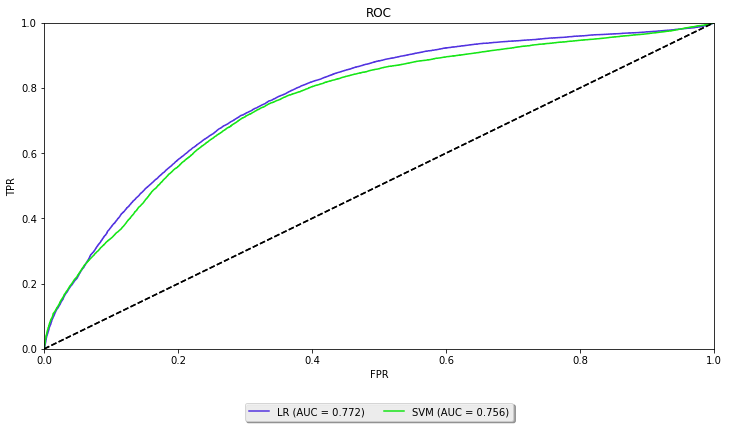

In [32]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
%matplotlib inline

def plotUnivariateROC(preds, truth, label_string):
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    #we are doing this as a special case because we are sending unfitted predictions into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)
        print('Warning:{} is worse than random!'.format(label_string))
    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

#We only need X and Y for data_train and data_test, 'mv' columns are not included in the dataframe below 
data_train=data_train.iloc[:,data_train.columns.slice_indexer(end='Y')]
data_test=data_test.iloc[:,data_test.columns.slice_indexer(end='Y')]

X_train=data_train.drop('Y', axis=1)
Y_train=data_train['Y']
X_test =data_test.drop('Y', axis=1)
Y_test =data_test['Y']

lr = LogisticRegression(C = 1e30)
lr.fit(X_train, Y_train)
preds_lr = lr.predict_proba(X_test)[:, 1]

SVM=SVC(kernel='linear',probability=True)
SVM.fit(X_train, Y_train)
preds_SVM=SVM.predict_proba(X_test)[:, 1]

fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

plotUnivariateROC(preds_lr, Y_test, 'LR')
plotUnivariateROC(preds_SVM, Y_test, 'SVM')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

***Answer:***    
1. LR model is better than SVM model because LR's AUC is larger than SVM's.  
2. Yes, we can see when FPR is less than 0.1, the LR curve is slightly below the SVM curve somewhere, which means LR underperform SVM in TPR metric there.

### Part 3: Model selection with cross-validation
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [47]:

def xValSVM(dataset, label_name, k, cs):
    kf = KFold(dataset.shape[0], n_folds = k, shuffle=True)
    aucs=dict()
    for c in cs:
        aucs[c]=list()
    kf_number=0 #In case there is one cruve, whose AUC is under 0.5, then we need to report it as a warning. kf_number tells you it's which fold.
    for train_index, test_index in kf:
        kf_number+=1
        X=dataset.drop(label_name,1)
        y=dataset[label_name]
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        for c in cs:
            SVM=SVC(C=c, kernel='linear',probability=True)
            SVM.fit(X_train,y_train)
            preds_SVM=SVM.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, preds_SVM)
            AUC_c_k = auc(fpr, tpr)
            if AUC_c_k < 0.5:
                fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
                AUC_c_k = auc(fpr, tpr)
                print('Warning:c{}f{} is worse than random!'.format(c,kf_number))
            aucs[c].append(AUC_c_k)
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

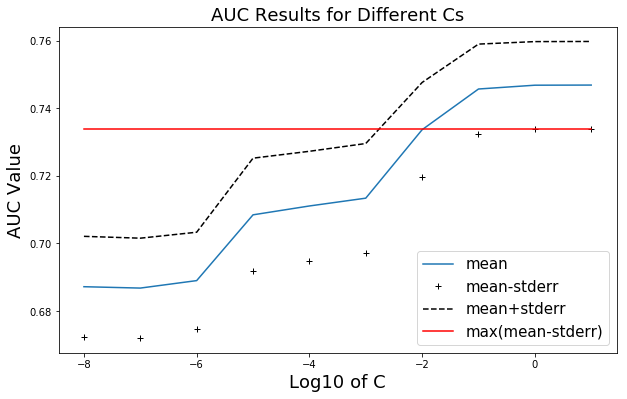

In [48]:
from scipy import stats

powers=np.arange(-8,2,dtype=np.float)
cs=10**powers
aucs=xValSVM(data_train,'Y',10, cs)
means=list()
StdErrs=list()
for c in aucs:
    means.append(np.mean(aucs[c]))
    StdErrs.append(stats.sem(aucs[c]))
difs=np.array(means)-np.array(StdErrs)
sums=np.array(means)+np.array(StdErrs)
dif_max=max(difs)

fig = plt.figure(figsize = (10, 6))
ax = plt.subplot(111)

plt.plot(np.log10(cs), means, label = 'mean')
plt.plot(np.log10(cs), difs, 'k+', label = 'mean-stderr')
plt.plot(np.log10(cs), sums, 'k--', label = 'mean+stderr')
plt.plot(np.log10(cs), dif_max * np.ones(len(cs)), color='r',label = 'max(mean-stderr)')
plt.legend(loc=4,prop={'size':15})

ax.set_xlabel('Log10 of C',fontsize=18)
ax.set_ylabel('AUC Value',fontsize=18)
plt.title('AUC Results for Different Cs',fontsize=18)

In [49]:
#For this block, I just wanna figure out between C=1 and C=10 which gets the best mean AUC.It turns out C=10 is slightly better than C=1.
df_Cs = pd.DataFrame(np.array(means), columns=['mean'], index=np.arange(-8,2))
df_Cs['stderr']=StdErrs
df_Cs['mean-stderr']=difs
df_Cs['mean+stderr']=sums
print('dif_max={}'.format(dif_max))
df_Cs.index.name='Log10C'
df_Cs

dif_max=0.7339596083886132


,mean,stderr,mean-stderr,mean+stderr
Log10C,,,,
-8,0.687196,0.014904,0.672292,0.702100
-7,0.686792,0.014764,0.672028,0.701555
-6,0.689002,0.014314,0.674688,0.703317
-5,0.708465,0.016765,0.691700,0.725231
-4,0.711086,0.016179,0.694907,0.727264
-3,0.713395,0.016170,0.697224,0.729565
-2,0.733650,0.013979,0.719671,0.747628
-1,0.745696,0.013287,0.732408,0.758983
0,0.746821,0.012899,0.733921,0.759720


***Answer:***    
No, except the last one(C=10), which is slightly better than C=1. This is because the out-of-the-box model of SVM means the C is default value(which is 1). From the graph we plotted, we can see that no mean AUC values exceed that of log10C=0(C=1) except the last one(C=10).

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


***Answer:***    
1. The one using the k-fold function is more suitable. We can see that in one set of k-fold results, the values flucatuate so much(there is a big distance between 'mean-stderr' and 'mean+stderr'). If we use k-fold function, we can get the average AUC values which shave the fluctuation of the dataset.  
2. It's not a worthy investment, since the difference between the results of Part2(52000 instances) and Part3(2000 instances) is only 0.01, even though Part2's result is better.

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



***Answer:***    
![Screenshot](Capture.png)  
Yes. In this figure, the curve increases rapidly at beginning and then slowly when the size of training set is after 100. When you do a fivefold cross-validation based on a size of training set 200, the performance of the classifier will be similar for a size of 200 and a size of 160,which is the size of cross-validation training set. But when the training set is so small, for example 50, the performance of the classifier will be considerably different for a size of 50 and a size of 40, which is the size of cross-validation training. Cross-validation training set(a size of 40) will perform with more errors, which a training set with 50 instances shouldn't have. In other words, cross-validation overestimate the prediction error for original training data. Hence as an estimate of errors, cross-validation would be biased upward.